# CLT Stopping Criterion Comparisons

Author: Jimmy Nguyen (nguyen.hoang.jimmy42@gmail.com)

This notebook compares Kronecker, lattice, Halton, and IID MC sequences when using CubQMCCLT. We will use the Keister function and Asian Option as examples.

In [1]:
import qmcpy as qp
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tolerances = np.array([1/x for x in [10, 20, 50, 75, 100, 250, 500, 750, 1000, 1500, 2000, 3000, 5000, 1e4]])
time_index = 0
n_index = 1

First, generate good alphas using alpha_generate() from Kronecker.ipynb. This will be the alpha used for our Kronecker objects. The call used was: `alpha_generate(d=4, n_al=5000, n=int(1e5), rd=2)`, giving us `[0.37105601, 0.15175581, 0.41276128, 0.35561725]`

In [3]:
alpha = np.array([0.37105601, 0.15175581, 0.41276128, 0.35561725])

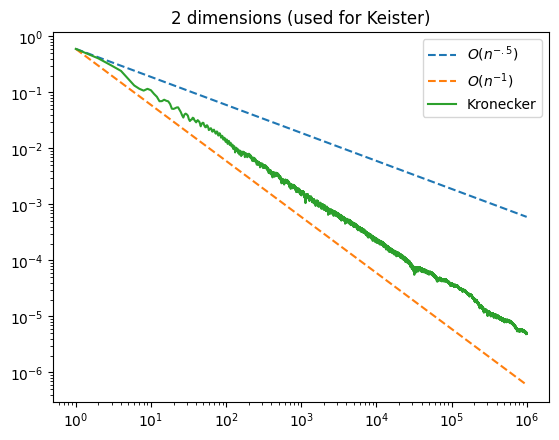

In [4]:
kronecker = qp.Kronecker(dimension=2, alpha=alpha[:2])
values = kronecker.periodic_discrepancy(int(1e6))
x = np.arange(1, int(1e6) + 1)
y = values[0] / x
y_half = values[0] / np.sqrt(x)

plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
plt.loglog(x, values, label="Kronecker")

plt.title('2 dimensions (used for Keister)')
plt.legend()
plt.show()

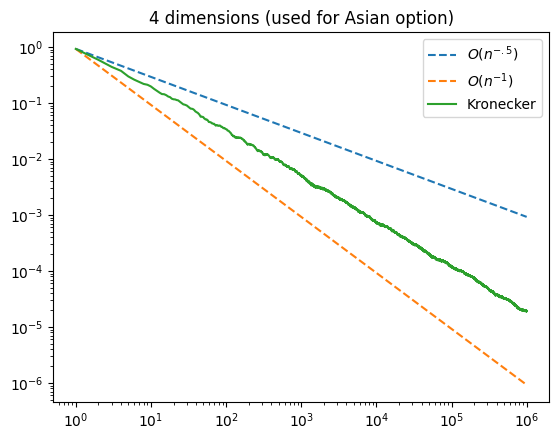

In [5]:
kronecker = qp.Kronecker(dimension=4, alpha=alpha)
values = kronecker.periodic_discrepancy(int(1e6))
x = np.arange(1, int(1e6) + 1)
y = values[0] / x
y_half = values[0] / np.sqrt(x)

plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
plt.loglog(x, values, label="Kronecker")

plt.title('4 dimensions (used for Asian option)')
plt.legend()
plt.show()

# Keister

In [6]:
keister_dimension = 2
keister_seed = 7
keister_sequences = [qp.Kronecker(dimension=keister_dimension, alpha=alpha[:keister_dimension], seed=keister_seed, randomize=True),
                     qp.Lattice(dimension=keister_dimension, seed=keister_seed),
                     qp.Halton(dimension=keister_dimension, seed=keister_seed)]

keister_results = np.empty((2, len(keister_sequences), len(tolerances)))

Calculate the time to integrate and also the total number of sample points generated for each tolerance value when integrating the Keister function.

In [7]:
for i, tolerance in enumerate(tolerances):
    for j, sequence in enumerate(keister_sequences):
        data = qp.CubQMCCLT(qp.Keister(sequence), abs_tol=tolerance).integrate()[1]
        keister_results[time_index][j][i] = data.time_integrate
        keister_results[n_index][j][i] = data.n_total

IID points are MC, not QMC so we use `CubMCCLT` instead.

In [ ]:
iid = qp.IIDStdUniform(dimension=keister_dimension, seed=keister_seed)
keister_iid_results = np.empty((2, len(tolerances[:-2])))
for i, tolerance in enumerate(tolerances[:-2]):
    data = qp.CubMCCLT(qp.Keister(iid), abs_tol = tolerance).integrate()[1]
    keister_iid_results[time_index][i] = data.time_integrate
    keister_iid_results[n_index][i] = data.n_total

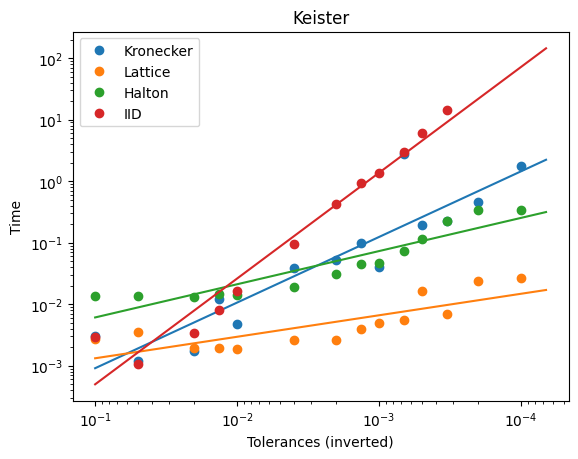

In [ ]:
sequences = ['Kronecker', 'Lattice', 'Halton']
x = np.linspace(0.1, 1/(1e4 + 5000))

for i, seq in enumerate(sequences):
    color = plt.gca()._get_lines.get_next_color()
    plt.loglog(tolerances, keister_results[time_index][i], 'o', label=seq, color=color)
    
    # curve fitting
    m, b = np.polyfit(np.log10(tolerances), np.log10(keister_results[time_index][i]), 1)
    plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

# repeat for IID
color = plt.gca()._get_lines.get_next_color()
plt.loglog(tolerances[:-2], keister_iid_results[time_index][:-2], 'o', label = 'IID', color=color)
m, b = np.polyfit(np.log10(tolerances[:-2]), np.log10(keister_iid_results[time_index][:-2]), 1)
plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

plt.gca().invert_xaxis()

plt.title('Keister')
plt.xlabel('Tolerances (inverted)')
plt.ylabel('Time')
plt.legend(loc='upper left')
plt.show()

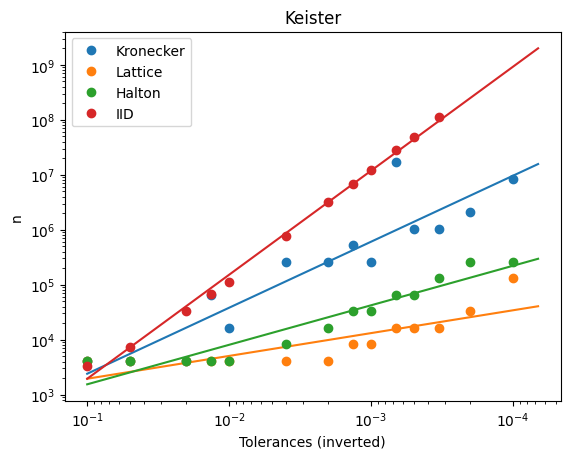

In [10]:
for i, seq in enumerate(sequences):
    color = plt.gca()._get_lines.get_next_color()
    plt.loglog(tolerances, keister_results[n_index][i], 'o', label=seq, color=color)
    
    # curve fitting
    m, b = np.polyfit(np.log10(tolerances), np.log10(keister_results[n_index][i]), 1)
    plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

# repeat for IID
color = plt.gca()._get_lines.get_next_color()
plt.loglog(tolerances[:-2], keister_iid_results[n_index], 'o', label = 'IID', color=color)
m, b = np.polyfit(np.log10(tolerances[:-2]), np.log10(keister_iid_results[n_index]), 1)
plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

plt.gca().invert_xaxis()

plt.title('Keister')
plt.xlabel('Tolerances (inverted)')
plt.ylabel('n')
plt.legend(loc='upper left')
plt.show()

# Asian Option

In [11]:
asian_dimension = 4
asian_seed = 7
asian_sequences = [qp.Kronecker(dimension=asian_dimension, alpha=alpha[:asian_dimension], seed=asian_seed, randomize=True),
                     qp.Lattice(dimension=asian_dimension, seed=asian_seed),
                     qp.Halton(dimension=asian_dimension, seed=asian_seed)]

asian_results = np.empty((2, len(asian_sequences), len(tolerances[:-3])))

In [12]:
for i, tolerance in enumerate(tolerances[:-3]):
    for j, sequence in enumerate(asian_sequences):
        data = qp.CubQMCCLT(qp.AsianOption(sequence), abs_tol=tolerance).integrate()[1]
        asian_results[time_index][j][i] = data.time_integrate
        asian_results[n_index][j][i] = data.n_total

In [13]:
iid = qp.IIDStdUniform(dimension=asian_dimension, seed=asian_seed)
asian_iid_results = np.empty((2, len(tolerances[:-4])))
for i, tolerance in enumerate(tolerances[:-4]):
    data = qp.CubMCCLT(qp.AsianOption(iid), abs_tol = tolerance).integrate()[1]
    asian_iid_results[time_index][i] = data.time_integrate
    asian_iid_results[n_index][i] = data.n_total

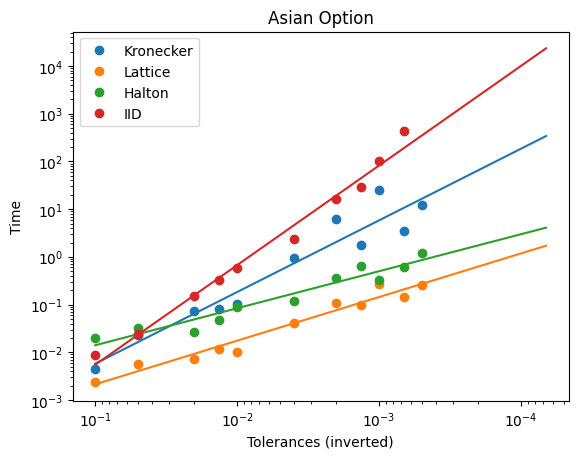

In [16]:
for i, seq in enumerate(sequences):
    color = plt.gca()._get_lines.get_next_color()
    plt.loglog(tolerances[:-3], asian_results[time_index][i], 'o', label=seq, color=color)
    
    # curve fitting
    m, b = np.polyfit(np.log10(tolerances[:-3]), np.log10(asian_results[time_index][i]), 1)
    plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

# repeat for IID
color = plt.gca()._get_lines.get_next_color()
plt.loglog(tolerances[:-4], asian_iid_results[time_index], 'o', label = 'IID', color=color)
m, b = np.polyfit(np.log10(tolerances[:-4]), np.log10(asian_iid_results[time_index]), 1)
plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

plt.gca().invert_xaxis()

plt.title('Asian Option')
plt.xlabel('Tolerances (inverted)')
plt.ylabel('Time')
plt.legend(loc='upper left')
plt.show()

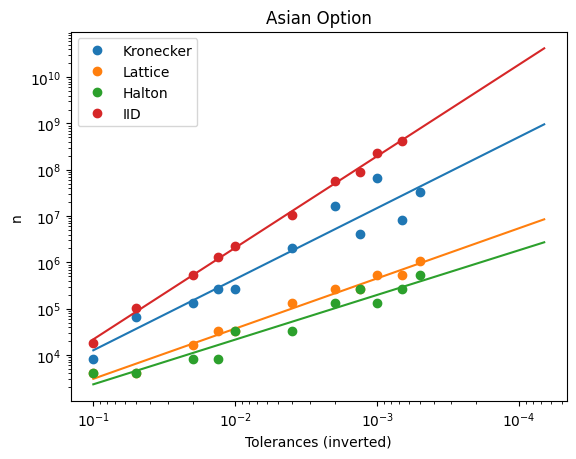

In [17]:
for i, seq in enumerate(sequences):
    color = plt.gca()._get_lines.get_next_color()
    plt.loglog(tolerances[:-3], asian_results[n_index][i], 'o', label=seq, color=color)
    
    # curve fitting
    m, b = np.polyfit(np.log10(tolerances[:-3]), np.log10(asian_results[n_index][i]), 1)
    plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

# repeat for IID
color = plt.gca()._get_lines.get_next_color()
plt.loglog(tolerances[:-4], asian_iid_results[n_index], 'o', label = 'IID', color=color)
m, b = np.polyfit(np.log10(tolerances[:-4]), np.log10(asian_iid_results[n_index]), 1)
plt.plot(x, 10 ** (m * np.log10(x) + b), color=color)

plt.gca().invert_xaxis()

plt.title('Asian Option')
plt.xlabel('Tolerances (inverted)')
plt.ylabel('n')
plt.legend(loc='upper left')
plt.show()